In [1]:
import cv2
import os
import pickle
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.image import img_to_array
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model

Using TensorFlow backend.


In [2]:
img_input_dir = os.path.dirname(os.getcwd()) + "/training_data"
data, labels = [], []
with os.scandir(img_input_dir) as it:
    for f in it:
        if f.name.endswith(".png"):
            p = img_input_dir+'/'+f.name
            # read image as grey scale
            img = cv2.imread(p, 0)
            # resize image into 20*20
            img = cv2.resize(img, (20, 20))
            data.append(img_to_array(img))
            label = f.name.split("_")[0]
            labels.append(label)


In [3]:
# scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
lb = LabelBinarizer().fit(labels)
# save label encoding
with open("captcha_label.dat", "wb") as f:
    pickle.dump(lb, f)

labels = lb.transform(labels)
# train test split
(X_train, X_test, Y_train, Y_test) = train_test_split(data, labels, test_size=0.25, random_state=0)

In [4]:
# build model
def build_model():
    model = Sequential()

    # First convolutional layer with max pooling
    model.add(Conv2D(20, (5, 5), padding="same", input_shape=(20, 20, 1), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Second convolutional layer with max pooling
    model.add(Conv2D(50, (5, 5), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Hidden layer with 500 nodes
    model.add(Flatten())
    model.add(Dense(500, activation="relu"))

    # Output layer with 32 nodes (one for each possible letter/number we predict)
    model.add(Dense(32, activation="softmax"))

    # Ask Keras to build the TensorFlow model behind the scenes
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    return model

In [5]:
captcha_model = build_model()
# image data generator
datagen = ImageDataGenerator()
# Train the neural network
BS = 32
EPOCHS = 10
print("training network...")
H = captcha_model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BS), 
                                validation_data=(X_test, Y_test), 
                                steps_per_epoch=len(X_train) // BS,
                                epochs=EPOCHS, verbose=1)
# Save the trained model
captcha_model.save("captcha_model.hdf5")

training network...
Epoch 1/10
915/915 [==============================] - 24s 26ms/step - loss: 0.1534 - acc: 0.9634 - val_loss: 0.0181 - val_acc: 0.9948
Epoch 2/10
915/915 [==============================] - 24s 27ms/step - loss: 0.0113 - acc: 0.9970 - val_loss: 0.0297 - val_acc: 0.9926
Epoch 3/10
915/915 [==============================] - 24s 26ms/step - loss: 0.0059 - acc: 0.9981 - val_loss: 0.0161 - val_acc: 0.9967
Epoch 4/10
915/915 [==============================] - 24s 26ms/step - loss: 0.0036 - acc: 0.9987 - val_loss: 0.0238 - val_acc: 0.9950
Epoch 5/10
915/915 [==============================] - 24s 26ms/step - loss: 0.0048 - acc: 0.9987 - val_loss: 0.0139 - val_acc: 0.9973
Epoch 6/10
915/915 [==============================] - 24s 26ms/step - loss: 0.0044 - acc: 0.9989 - val_loss: 0.0128 - val_acc: 0.9977
Epoch 7/10
915/915 [==============================] - 24s 26ms/step - loss: 0.0024 - acc: 0.9994 - val_loss: 0.0164 - val_acc: 0.9963
Epoch 8/10
915/915 [======================

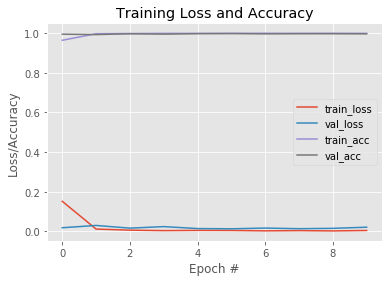

In [6]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.show()

In [7]:
plot_model(captcha_model, to_file='captcha_model.png')